# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

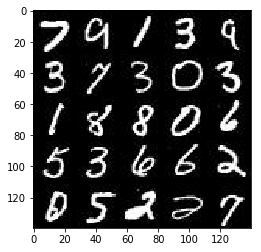

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

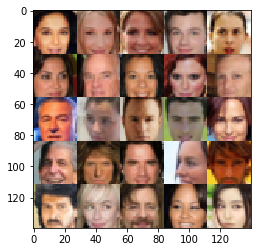

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    inputs_real = tf.placeholder(tf.float32, (None, image_width,image_height,image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')

    learn_rate = tf.placeholder(tf.float32, name = 'learn_rate')
    return inputs_real, inputs_z, learn_rate



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
?tf.layers.conv2d

In [7]:
def discriminator(images, reuse=False,  alpha=0.01):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    leaky_relu = lambda x : tf.maximum(alpha * x, x)
    
    def conv(inputs,filters,batch_norm=True):
        outputs = tf.layers.conv2d(inputs=inputs,
                                  filters=filters, kernel_size=5
                                  , strides= 2,padding='same')

        if batch_norm: # only do for input layer
            outputs = tf.layers.batch_normalization(outputs, training = True) 
        return leaky_relu(outputs)
    
    with tf.variable_scope("discriminator", reuse=reuse):
        x1 = conv(images,64, batch_norm=False)
        x2 = conv(x1, 128)
        x3 = conv(x2, 256)
        
        flattened = tf.reshape(x3, (-1,4 *4 *256))
        logits = tf.layers.dense(flattened,1)
        out = tf.sigmoid(logits)
        
        return out, logits
        
        
        
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
?tf.layers.conv2d_transpose

In [9]:
def generator(z, out_channel_dim, is_train=True,alpha=0.01):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    leaky_relu = lambda x: tf.maximum( alpha *x, x)
    with tf.variable_scope("generator", reuse=not is_train):
        x1 = tf.layers.dense(z, 7 *7 *512)
        x1 = tf.reshape(x1, (-1,7,7,512))
        x1 = tf.layers.batch_normalization(x1,training=is_train)
        x1 = leaky_relu(x1)
    
        x2 = tf.layers.conv2d_transpose(x1,256,6,1,'same')
        x2 = tf.layers.batch_normalization(x2,training=is_train)
        x2 = leaky_relu(x2)
        
        x3 = tf.layers.conv2d_transpose(x2,128,5,2,'same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = leaky_relu(x3)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5,2,'same')
        out = tf.tanh(logits)
        
    
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.9):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim=out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): 
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

**References**

https://discussions.udacity.com/t/stuck-in-training-failedpreconditionerror-attempting-to-use-uninitialized-value-generator-dense-kernel/318655/7

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                steps +=1
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Batch {}...".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, show_n_images, input_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Batch 10... Discriminator Loss: 0.8974... Generator Loss: 0.7980
Epoch 1/2... Batch 20... Discriminator Loss: 0.9808... Generator Loss: 0.6546
Epoch 1/2... Batch 30... Discriminator Loss: 0.9765... Generator Loss: 0.6280
Epoch 1/2... Batch 40... Discriminator Loss: 0.4568... Generator Loss: 1.0881
Epoch 1/2... Batch 50... Discriminator Loss: 0.0957... Generator Loss: 2.9457
Epoch 1/2... Batch 60... Discriminator Loss: 0.8469... Generator Loss: 9.5051
Epoch 1/2... Batch 70... Discriminator Loss: 0.2417... Generator Loss: 2.0497
Epoch 1/2... Batch 80... Discriminator Loss: 0.2506... Generator Loss: 2.2496
Epoch 1/2... Batch 90... Discriminator Loss: 0.2636... Generator Loss: 2.1845
Epoch 1/2... Batch 100... Discriminator Loss: 0.2395... Generator Loss: 2.4399


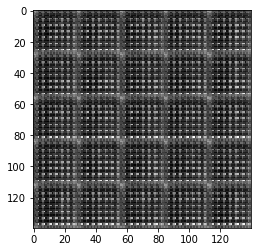

Epoch 1/2... Batch 110... Discriminator Loss: 2.8343... Generator Loss: 0.1036
Epoch 1/2... Batch 120... Discriminator Loss: 0.6844... Generator Loss: 1.5843
Epoch 1/2... Batch 130... Discriminator Loss: 0.4685... Generator Loss: 1.8514
Epoch 1/2... Batch 140... Discriminator Loss: 0.6623... Generator Loss: 1.9479
Epoch 1/2... Batch 150... Discriminator Loss: 1.0573... Generator Loss: 2.4083
Epoch 1/2... Batch 160... Discriminator Loss: 0.7140... Generator Loss: 2.3440
Epoch 1/2... Batch 170... Discriminator Loss: 0.7212... Generator Loss: 1.7883
Epoch 1/2... Batch 180... Discriminator Loss: 0.7917... Generator Loss: 1.4113
Epoch 1/2... Batch 190... Discriminator Loss: 2.0457... Generator Loss: 4.1097
Epoch 1/2... Batch 200... Discriminator Loss: 0.8324... Generator Loss: 1.6507


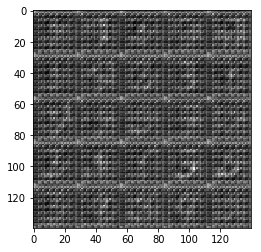

Epoch 1/2... Batch 210... Discriminator Loss: 1.2696... Generator Loss: 0.4985
Epoch 1/2... Batch 220... Discriminator Loss: 0.7438... Generator Loss: 1.2837
Epoch 1/2... Batch 230... Discriminator Loss: 1.7425... Generator Loss: 0.2737
Epoch 1/2... Batch 240... Discriminator Loss: 0.7393... Generator Loss: 1.2372
Epoch 1/2... Batch 250... Discriminator Loss: 0.9600... Generator Loss: 0.7592
Epoch 1/2... Batch 260... Discriminator Loss: 1.1204... Generator Loss: 0.7012
Epoch 1/2... Batch 270... Discriminator Loss: 1.3046... Generator Loss: 2.6977
Epoch 1/2... Batch 280... Discriminator Loss: 1.0669... Generator Loss: 1.3149
Epoch 1/2... Batch 290... Discriminator Loss: 0.8351... Generator Loss: 1.1288
Epoch 1/2... Batch 300... Discriminator Loss: 0.8908... Generator Loss: 1.4569


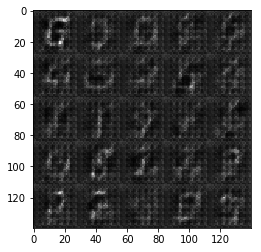

Epoch 1/2... Batch 310... Discriminator Loss: 1.0746... Generator Loss: 1.6708
Epoch 1/2... Batch 320... Discriminator Loss: 0.8736... Generator Loss: 1.3827
Epoch 1/2... Batch 330... Discriminator Loss: 1.0105... Generator Loss: 1.1697
Epoch 1/2... Batch 340... Discriminator Loss: 1.4007... Generator Loss: 0.3682
Epoch 1/2... Batch 350... Discriminator Loss: 0.9897... Generator Loss: 0.7205
Epoch 1/2... Batch 360... Discriminator Loss: 1.0049... Generator Loss: 0.9154
Epoch 1/2... Batch 370... Discriminator Loss: 0.9968... Generator Loss: 1.1387
Epoch 1/2... Batch 380... Discriminator Loss: 1.0154... Generator Loss: 1.3435
Epoch 1/2... Batch 390... Discriminator Loss: 1.0710... Generator Loss: 1.4150
Epoch 1/2... Batch 400... Discriminator Loss: 1.6189... Generator Loss: 0.3112


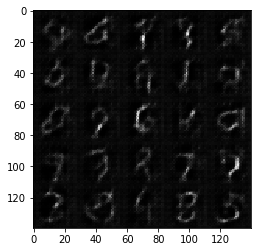

Epoch 1/2... Batch 410... Discriminator Loss: 0.8214... Generator Loss: 1.4802
Epoch 1/2... Batch 420... Discriminator Loss: 1.0075... Generator Loss: 1.5023
Epoch 1/2... Batch 430... Discriminator Loss: 1.0445... Generator Loss: 0.7662
Epoch 1/2... Batch 440... Discriminator Loss: 0.9665... Generator Loss: 1.5306
Epoch 1/2... Batch 450... Discriminator Loss: 0.8469... Generator Loss: 0.9547
Epoch 1/2... Batch 460... Discriminator Loss: 1.0658... Generator Loss: 0.5924
Epoch 1/2... Batch 470... Discriminator Loss: 0.9745... Generator Loss: 1.6192
Epoch 1/2... Batch 480... Discriminator Loss: 1.0028... Generator Loss: 0.8953
Epoch 1/2... Batch 490... Discriminator Loss: 1.1705... Generator Loss: 0.4908
Epoch 1/2... Batch 500... Discriminator Loss: 0.9936... Generator Loss: 0.8440


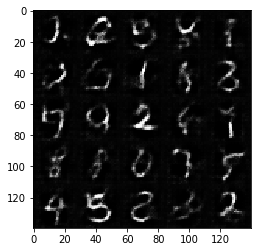

Epoch 1/2... Batch 510... Discriminator Loss: 0.9375... Generator Loss: 1.0698
Epoch 1/2... Batch 520... Discriminator Loss: 1.1470... Generator Loss: 0.5551
Epoch 1/2... Batch 530... Discriminator Loss: 1.0040... Generator Loss: 1.2044
Epoch 1/2... Batch 540... Discriminator Loss: 1.0454... Generator Loss: 0.7479
Epoch 1/2... Batch 550... Discriminator Loss: 1.2588... Generator Loss: 0.5095
Epoch 1/2... Batch 560... Discriminator Loss: 1.4607... Generator Loss: 0.3472
Epoch 1/2... Batch 570... Discriminator Loss: 1.1810... Generator Loss: 0.5763
Epoch 1/2... Batch 580... Discriminator Loss: 0.9869... Generator Loss: 0.7897
Epoch 1/2... Batch 590... Discriminator Loss: 0.9639... Generator Loss: 0.9634
Epoch 1/2... Batch 600... Discriminator Loss: 1.2136... Generator Loss: 0.4994


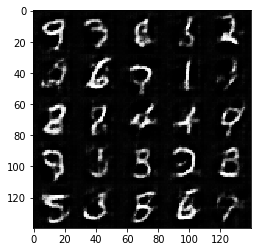

Epoch 1/2... Batch 610... Discriminator Loss: 1.0377... Generator Loss: 1.0790
Epoch 1/2... Batch 620... Discriminator Loss: 1.0308... Generator Loss: 0.7739
Epoch 1/2... Batch 630... Discriminator Loss: 0.9949... Generator Loss: 1.4140
Epoch 1/2... Batch 640... Discriminator Loss: 1.1749... Generator Loss: 0.5528
Epoch 1/2... Batch 650... Discriminator Loss: 0.9819... Generator Loss: 0.8638
Epoch 1/2... Batch 660... Discriminator Loss: 1.0946... Generator Loss: 1.0284
Epoch 1/2... Batch 670... Discriminator Loss: 1.4397... Generator Loss: 0.3405
Epoch 1/2... Batch 680... Discriminator Loss: 0.9654... Generator Loss: 0.7851
Epoch 1/2... Batch 690... Discriminator Loss: 0.9706... Generator Loss: 1.1462
Epoch 1/2... Batch 700... Discriminator Loss: 0.9753... Generator Loss: 1.1639


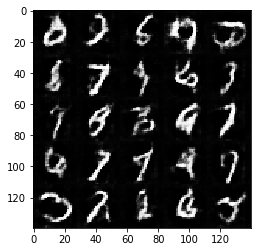

Epoch 1/2... Batch 710... Discriminator Loss: 1.4704... Generator Loss: 0.3788
Epoch 1/2... Batch 720... Discriminator Loss: 1.4808... Generator Loss: 0.3266
Epoch 1/2... Batch 730... Discriminator Loss: 1.2392... Generator Loss: 0.4546
Epoch 1/2... Batch 740... Discriminator Loss: 0.9754... Generator Loss: 0.9818
Epoch 1/2... Batch 750... Discriminator Loss: 0.8690... Generator Loss: 1.0504
Epoch 1/2... Batch 760... Discriminator Loss: 0.9248... Generator Loss: 0.9504
Epoch 1/2... Batch 770... Discriminator Loss: 0.9788... Generator Loss: 0.8994
Epoch 1/2... Batch 780... Discriminator Loss: 1.0517... Generator Loss: 0.7281
Epoch 1/2... Batch 790... Discriminator Loss: 0.9526... Generator Loss: 0.7232
Epoch 1/2... Batch 800... Discriminator Loss: 0.9555... Generator Loss: 0.7846


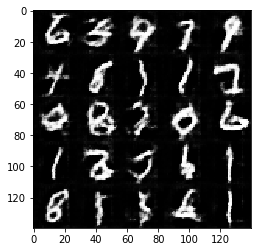

Epoch 1/2... Batch 810... Discriminator Loss: 0.9817... Generator Loss: 1.8308
Epoch 1/2... Batch 820... Discriminator Loss: 0.8331... Generator Loss: 1.0902
Epoch 1/2... Batch 830... Discriminator Loss: 1.0021... Generator Loss: 0.7785
Epoch 1/2... Batch 840... Discriminator Loss: 0.9204... Generator Loss: 0.7936
Epoch 1/2... Batch 850... Discriminator Loss: 1.3239... Generator Loss: 0.4435
Epoch 1/2... Batch 860... Discriminator Loss: 0.9529... Generator Loss: 0.8394
Epoch 1/2... Batch 870... Discriminator Loss: 0.8216... Generator Loss: 0.9721
Epoch 1/2... Batch 880... Discriminator Loss: 1.0843... Generator Loss: 0.6181
Epoch 1/2... Batch 890... Discriminator Loss: 1.0793... Generator Loss: 0.6187
Epoch 1/2... Batch 900... Discriminator Loss: 1.0361... Generator Loss: 0.7159


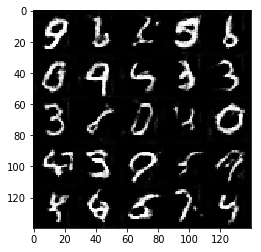

Epoch 1/2... Batch 910... Discriminator Loss: 1.4000... Generator Loss: 0.3969
Epoch 1/2... Batch 920... Discriminator Loss: 0.9016... Generator Loss: 1.2535
Epoch 1/2... Batch 930... Discriminator Loss: 0.9880... Generator Loss: 0.7543
Epoch 2/2... Batch 10... Discriminator Loss: 1.1527... Generator Loss: 0.8744
Epoch 2/2... Batch 20... Discriminator Loss: 0.9575... Generator Loss: 1.0259
Epoch 2/2... Batch 30... Discriminator Loss: 0.9810... Generator Loss: 0.7371
Epoch 2/2... Batch 40... Discriminator Loss: 1.1344... Generator Loss: 0.5501
Epoch 2/2... Batch 50... Discriminator Loss: 1.2899... Generator Loss: 0.4279
Epoch 2/2... Batch 60... Discriminator Loss: 1.0908... Generator Loss: 0.5800
Epoch 2/2... Batch 330... Discriminator Loss: 1.9691... Generator Loss: 0.1887
Epoch 2/2... Batch 340... Discriminator Loss: 1.2957... Generator Loss: 0.4451
Epoch 2/2... Batch 350... Discriminator Loss: 1.1572... Generator Loss: 0.5120
Epoch 2/2... Batch 360... Discriminator Loss: 0.8141... Ge

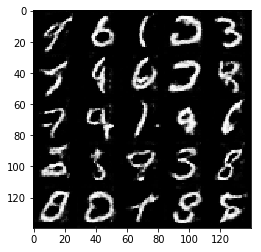

Epoch 2/2... Batch 410... Discriminator Loss: 0.7780... Generator Loss: 1.2445
Epoch 2/2... Batch 420... Discriminator Loss: 0.8840... Generator Loss: 0.8976
Epoch 2/2... Batch 430... Discriminator Loss: 0.9405... Generator Loss: 0.7415
Epoch 2/2... Batch 440... Discriminator Loss: 1.1311... Generator Loss: 0.5193
Epoch 2/2... Batch 450... Discriminator Loss: 0.7971... Generator Loss: 1.0515
Epoch 2/2... Batch 460... Discriminator Loss: 0.9081... Generator Loss: 0.8378
Epoch 2/2... Batch 470... Discriminator Loss: 0.9590... Generator Loss: 0.7560
Epoch 2/2... Batch 480... Discriminator Loss: 0.7948... Generator Loss: 0.9677
Epoch 2/2... Batch 490... Discriminator Loss: 0.7945... Generator Loss: 1.3435
Epoch 2/2... Batch 500... Discriminator Loss: 0.8751... Generator Loss: 0.8619


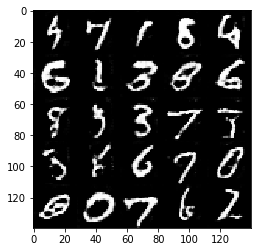

Epoch 2/2... Batch 510... Discriminator Loss: 2.1157... Generator Loss: 0.2410
Epoch 2/2... Batch 520... Discriminator Loss: 0.8225... Generator Loss: 0.8815
Epoch 2/2... Batch 530... Discriminator Loss: 0.7961... Generator Loss: 0.8990
Epoch 2/2... Batch 540... Discriminator Loss: 1.3668... Generator Loss: 0.4128
Epoch 2/2... Batch 550... Discriminator Loss: 1.4914... Generator Loss: 0.3122
Epoch 2/2... Batch 560... Discriminator Loss: 0.6423... Generator Loss: 1.6160
Epoch 2/2... Batch 570... Discriminator Loss: 0.6467... Generator Loss: 1.2737
Epoch 2/2... Batch 580... Discriminator Loss: 0.9983... Generator Loss: 0.8220
Epoch 2/2... Batch 590... Discriminator Loss: 1.1739... Generator Loss: 0.5368
Epoch 2/2... Batch 600... Discriminator Loss: 0.8404... Generator Loss: 0.9859


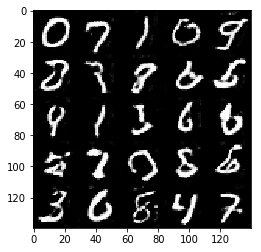

Epoch 2/2... Batch 610... Discriminator Loss: 0.7970... Generator Loss: 1.3014
Epoch 2/2... Batch 620... Discriminator Loss: 0.8149... Generator Loss: 1.0399
Epoch 2/2... Batch 630... Discriminator Loss: 0.6649... Generator Loss: 1.1335
Epoch 2/2... Batch 640... Discriminator Loss: 1.4323... Generator Loss: 0.3557
Epoch 2/2... Batch 650... Discriminator Loss: 0.6864... Generator Loss: 1.6880
Epoch 2/2... Batch 660... Discriminator Loss: 0.8620... Generator Loss: 0.8833
Epoch 2/2... Batch 670... Discriminator Loss: 2.6363... Generator Loss: 0.1995
Epoch 2/2... Batch 680... Discriminator Loss: 0.7894... Generator Loss: 1.0258
Epoch 2/2... Batch 690... Discriminator Loss: 0.9766... Generator Loss: 0.7343
Epoch 2/2... Batch 700... Discriminator Loss: 0.7914... Generator Loss: 1.0395


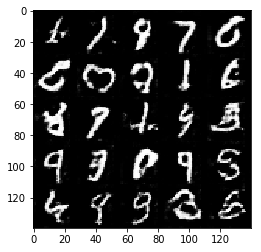

Epoch 2/2... Batch 710... Discriminator Loss: 0.7353... Generator Loss: 0.9989
Epoch 2/2... Batch 720... Discriminator Loss: 0.9064... Generator Loss: 0.8230
Epoch 2/2... Batch 730... Discriminator Loss: 0.8396... Generator Loss: 0.9013
Epoch 2/2... Batch 740... Discriminator Loss: 0.8260... Generator Loss: 0.8976
Epoch 2/2... Batch 750... Discriminator Loss: 0.6479... Generator Loss: 1.6394
Epoch 2/2... Batch 760... Discriminator Loss: 0.8102... Generator Loss: 1.8287
Epoch 2/2... Batch 770... Discriminator Loss: 1.0393... Generator Loss: 0.5865
Epoch 2/2... Batch 780... Discriminator Loss: 0.6435... Generator Loss: 1.1008
Epoch 2/2... Batch 790... Discriminator Loss: 1.1383... Generator Loss: 0.5653
Epoch 2/2... Batch 800... Discriminator Loss: 1.2879... Generator Loss: 0.6210


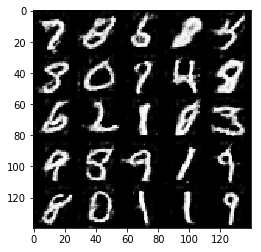

Epoch 2/2... Batch 810... Discriminator Loss: 0.8913... Generator Loss: 1.5864
Epoch 2/2... Batch 820... Discriminator Loss: 0.7834... Generator Loss: 1.4153
Epoch 2/2... Batch 830... Discriminator Loss: 0.8798... Generator Loss: 0.8973
Epoch 2/2... Batch 840... Discriminator Loss: 0.7771... Generator Loss: 0.8938
Epoch 2/2... Batch 850... Discriminator Loss: 0.7919... Generator Loss: 0.9605
Epoch 2/2... Batch 860... Discriminator Loss: 0.6250... Generator Loss: 1.2835
Epoch 2/2... Batch 870... Discriminator Loss: 0.6014... Generator Loss: 1.8464
Epoch 2/2... Batch 880... Discriminator Loss: 0.6944... Generator Loss: 1.4860
Epoch 2/2... Batch 890... Discriminator Loss: 1.5301... Generator Loss: 0.3574
Epoch 2/2... Batch 900... Discriminator Loss: 0.8440... Generator Loss: 0.7639


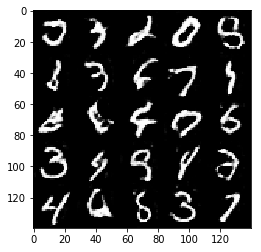

Epoch 2/2... Batch 910... Discriminator Loss: 0.7351... Generator Loss: 0.9575
Epoch 2/2... Batch 920... Discriminator Loss: 0.5828... Generator Loss: 1.7740
Epoch 2/2... Batch 930... Discriminator Loss: 0.6957... Generator Loss: 1.5548


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Batch 10... Discriminator Loss: 1.0906... Generator Loss: 0.7861
Epoch 1/1... Batch 20... Discriminator Loss: 1.0678... Generator Loss: 0.5546
Epoch 1/1... Batch 30... Discriminator Loss: 0.2775... Generator Loss: 2.2191
Epoch 1/1... Batch 40... Discriminator Loss: 0.6726... Generator Loss: 1.3178
Epoch 1/1... Batch 50... Discriminator Loss: 1.8280... Generator Loss: 0.2793
Epoch 1/1... Batch 60... Discriminator Loss: 1.1360... Generator Loss: 0.5228
Epoch 1/1... Batch 70... Discriminator Loss: 0.4187... Generator Loss: 1.6226
Epoch 1/1... Batch 80... Discriminator Loss: 0.3345... Generator Loss: 2.5218
Epoch 1/1... Batch 90... Discriminator Loss: 0.4120... Generator Loss: 2.4321
Epoch 1/1... Batch 100... Discriminator Loss: 0.5777... Generator Loss: 1.2606


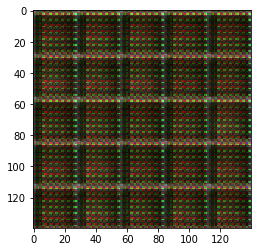

Epoch 1/1... Batch 110... Discriminator Loss: 0.5028... Generator Loss: 1.9148
Epoch 1/1... Batch 120... Discriminator Loss: 0.8573... Generator Loss: 1.9790
Epoch 1/1... Batch 130... Discriminator Loss: 0.8457... Generator Loss: 1.6097
Epoch 1/1... Batch 140... Discriminator Loss: 0.8782... Generator Loss: 1.1980
Epoch 1/1... Batch 150... Discriminator Loss: 0.8142... Generator Loss: 1.0101
Epoch 1/1... Batch 160... Discriminator Loss: 1.0507... Generator Loss: 0.8430
Epoch 1/1... Batch 170... Discriminator Loss: 0.7578... Generator Loss: 1.0392
Epoch 1/1... Batch 180... Discriminator Loss: 0.5217... Generator Loss: 1.6147
Epoch 1/1... Batch 190... Discriminator Loss: 0.7028... Generator Loss: 1.1680
Epoch 1/1... Batch 200... Discriminator Loss: 0.9550... Generator Loss: 0.9636


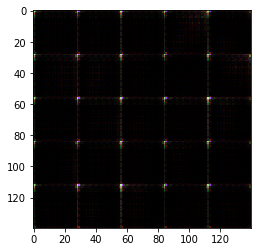

Epoch 1/1... Batch 210... Discriminator Loss: 0.4970... Generator Loss: 1.7876
Epoch 1/1... Batch 220... Discriminator Loss: 0.5116... Generator Loss: 1.7322
Epoch 1/1... Batch 230... Discriminator Loss: 0.8119... Generator Loss: 1.3260
Epoch 1/1... Batch 240... Discriminator Loss: 0.7888... Generator Loss: 1.6427
Epoch 1/1... Batch 250... Discriminator Loss: 1.2851... Generator Loss: 0.6726
Epoch 1/1... Batch 260... Discriminator Loss: 0.9937... Generator Loss: 0.8235
Epoch 1/1... Batch 270... Discriminator Loss: 0.6701... Generator Loss: 1.2383
Epoch 1/1... Batch 280... Discriminator Loss: 1.2331... Generator Loss: 1.6866
Epoch 1/1... Batch 290... Discriminator Loss: 1.1136... Generator Loss: 0.8021
Epoch 1/1... Batch 300... Discriminator Loss: 1.0290... Generator Loss: 0.8902


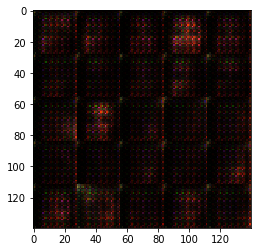

Epoch 1/1... Batch 310... Discriminator Loss: 1.0952... Generator Loss: 1.1749
Epoch 1/1... Batch 320... Discriminator Loss: 0.9938... Generator Loss: 1.4593
Epoch 1/1... Batch 330... Discriminator Loss: 0.8415... Generator Loss: 1.2541
Epoch 1/1... Batch 340... Discriminator Loss: 1.1862... Generator Loss: 0.8356
Epoch 1/1... Batch 350... Discriminator Loss: 0.7641... Generator Loss: 1.4861
Epoch 1/1... Batch 360... Discriminator Loss: 1.0645... Generator Loss: 0.7471
Epoch 1/1... Batch 370... Discriminator Loss: 0.9751... Generator Loss: 1.0115
Epoch 1/1... Batch 380... Discriminator Loss: 0.6241... Generator Loss: 1.2934
Epoch 1/1... Batch 390... Discriminator Loss: 0.9204... Generator Loss: 1.6644
Epoch 1/1... Batch 400... Discriminator Loss: 1.1679... Generator Loss: 1.9315


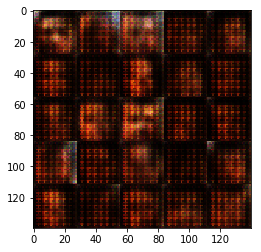

Epoch 1/1... Batch 410... Discriminator Loss: 1.1149... Generator Loss: 1.0393
Epoch 1/1... Batch 420... Discriminator Loss: 1.1125... Generator Loss: 0.9649
Epoch 1/1... Batch 430... Discriminator Loss: 1.0720... Generator Loss: 0.7427
Epoch 1/1... Batch 440... Discriminator Loss: 1.0507... Generator Loss: 1.0835
Epoch 1/1... Batch 450... Discriminator Loss: 0.9095... Generator Loss: 1.0517
Epoch 1/1... Batch 460... Discriminator Loss: 0.9941... Generator Loss: 0.9751
Epoch 1/1... Batch 470... Discriminator Loss: 1.1541... Generator Loss: 0.6348
Epoch 1/1... Batch 480... Discriminator Loss: 0.9851... Generator Loss: 0.7965
Epoch 1/1... Batch 490... Discriminator Loss: 1.1397... Generator Loss: 0.7620
Epoch 1/1... Batch 500... Discriminator Loss: 1.5481... Generator Loss: 0.4670


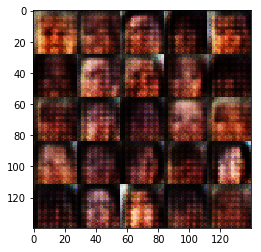

Epoch 1/1... Batch 510... Discriminator Loss: 1.1564... Generator Loss: 0.7860
Epoch 1/1... Batch 520... Discriminator Loss: 1.2561... Generator Loss: 0.6353
Epoch 1/1... Batch 530... Discriminator Loss: 0.8484... Generator Loss: 0.9372
Epoch 1/1... Batch 540... Discriminator Loss: 1.1285... Generator Loss: 0.7310
Epoch 1/1... Batch 550... Discriminator Loss: 2.0061... Generator Loss: 0.2317
Epoch 1/1... Batch 560... Discriminator Loss: 0.9803... Generator Loss: 0.8652
Epoch 1/1... Batch 570... Discriminator Loss: 0.8181... Generator Loss: 1.8140
Epoch 1/1... Batch 580... Discriminator Loss: 1.1954... Generator Loss: 0.6556
Epoch 1/1... Batch 590... Discriminator Loss: 1.5658... Generator Loss: 0.3749
Epoch 1/1... Batch 600... Discriminator Loss: 1.0668... Generator Loss: 1.2619


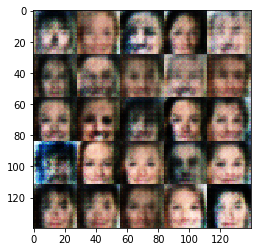

Epoch 1/1... Batch 610... Discriminator Loss: 1.4188... Generator Loss: 0.4867
Epoch 1/1... Batch 620... Discriminator Loss: 1.0323... Generator Loss: 1.1562
Epoch 1/1... Batch 630... Discriminator Loss: 0.6623... Generator Loss: 1.7309
Epoch 1/1... Batch 640... Discriminator Loss: 1.3265... Generator Loss: 0.5041
Epoch 1/1... Batch 650... Discriminator Loss: 0.8902... Generator Loss: 1.1511
Epoch 1/1... Batch 660... Discriminator Loss: 0.8172... Generator Loss: 1.9664
Epoch 1/1... Batch 670... Discriminator Loss: 0.8739... Generator Loss: 1.0241
Epoch 1/1... Batch 680... Discriminator Loss: 1.1845... Generator Loss: 0.6104
Epoch 1/1... Batch 690... Discriminator Loss: 1.1957... Generator Loss: 0.7084
Epoch 1/1... Batch 700... Discriminator Loss: 0.6053... Generator Loss: 1.7476


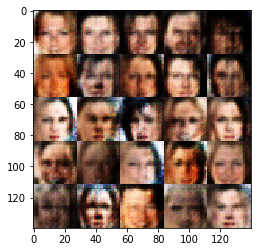

Epoch 1/1... Batch 710... Discriminator Loss: 1.2804... Generator Loss: 1.8795
Epoch 1/1... Batch 720... Discriminator Loss: 1.0072... Generator Loss: 0.9057
Epoch 1/1... Batch 730... Discriminator Loss: 1.5669... Generator Loss: 0.3117
Epoch 1/1... Batch 740... Discriminator Loss: 0.5690... Generator Loss: 2.5359
Epoch 1/1... Batch 750... Discriminator Loss: 1.3309... Generator Loss: 0.4695
Epoch 1/1... Batch 760... Discriminator Loss: 1.9955... Generator Loss: 0.2100
Epoch 1/1... Batch 770... Discriminator Loss: 1.0210... Generator Loss: 0.6334
Epoch 1/1... Batch 780... Discriminator Loss: 0.8367... Generator Loss: 1.0004
Epoch 1/1... Batch 790... Discriminator Loss: 1.1515... Generator Loss: 0.5919
Epoch 1/1... Batch 800... Discriminator Loss: 0.4479... Generator Loss: 2.3741


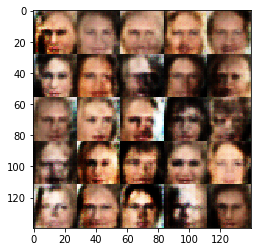

Epoch 1/1... Batch 810... Discriminator Loss: 0.9460... Generator Loss: 0.8728
Epoch 1/1... Batch 820... Discriminator Loss: 0.8586... Generator Loss: 0.8558
Epoch 1/1... Batch 830... Discriminator Loss: 0.8474... Generator Loss: 0.8496
Epoch 1/1... Batch 840... Discriminator Loss: 0.2859... Generator Loss: 2.6497
Epoch 1/1... Batch 850... Discriminator Loss: 0.4534... Generator Loss: 1.9346
Epoch 1/1... Batch 860... Discriminator Loss: 0.9789... Generator Loss: 0.6763
Epoch 1/1... Batch 870... Discriminator Loss: 1.4136... Generator Loss: 1.2947
Epoch 1/1... Batch 880... Discriminator Loss: 0.8314... Generator Loss: 0.9675
Epoch 1/1... Batch 890... Discriminator Loss: 0.6597... Generator Loss: 1.4888
Epoch 1/1... Batch 900... Discriminator Loss: 0.4932... Generator Loss: 2.5072


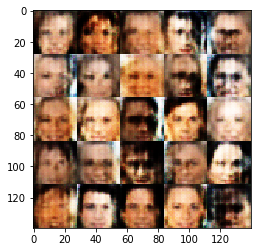

Epoch 1/1... Batch 910... Discriminator Loss: 0.7142... Generator Loss: 1.1806
Epoch 1/1... Batch 920... Discriminator Loss: 1.4323... Generator Loss: 3.7082
Epoch 1/1... Batch 930... Discriminator Loss: 1.1892... Generator Loss: 1.2904
Epoch 1/1... Batch 940... Discriminator Loss: 0.6416... Generator Loss: 1.2331
Epoch 1/1... Batch 950... Discriminator Loss: 0.9869... Generator Loss: 1.5439
Epoch 1/1... Batch 960... Discriminator Loss: 1.1165... Generator Loss: 0.5849
Epoch 1/1... Batch 970... Discriminator Loss: 0.6299... Generator Loss: 1.3506
Epoch 1/1... Batch 980... Discriminator Loss: 0.6927... Generator Loss: 1.5189
Epoch 1/1... Batch 990... Discriminator Loss: 1.1159... Generator Loss: 1.4149
Epoch 1/1... Batch 1000... Discriminator Loss: 0.8481... Generator Loss: 3.0610


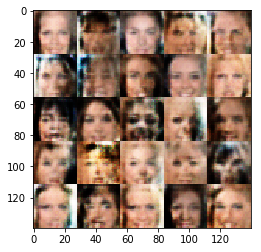

Epoch 1/1... Batch 1010... Discriminator Loss: 1.0983... Generator Loss: 0.8908
Epoch 1/1... Batch 1020... Discriminator Loss: 1.2130... Generator Loss: 0.5412
Epoch 1/1... Batch 1030... Discriminator Loss: 0.5289... Generator Loss: 2.3135
Epoch 1/1... Batch 1040... Discriminator Loss: 0.5828... Generator Loss: 1.6520
Epoch 1/1... Batch 1050... Discriminator Loss: 1.4941... Generator Loss: 0.3790
Epoch 1/1... Batch 1060... Discriminator Loss: 0.7111... Generator Loss: 1.6927
Epoch 1/1... Batch 1070... Discriminator Loss: 1.1047... Generator Loss: 0.5930
Epoch 1/1... Batch 1080... Discriminator Loss: 1.1736... Generator Loss: 0.7700
Epoch 1/1... Batch 1090... Discriminator Loss: 2.6571... Generator Loss: 0.1010
Epoch 1/1... Batch 1100... Discriminator Loss: 0.9055... Generator Loss: 1.0190


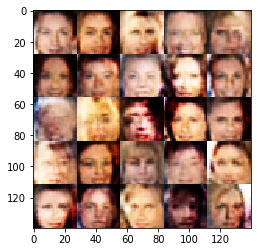

Epoch 1/1... Batch 1110... Discriminator Loss: 1.3995... Generator Loss: 1.8649
Epoch 1/1... Batch 1120... Discriminator Loss: 1.2869... Generator Loss: 0.4718
Epoch 1/1... Batch 1130... Discriminator Loss: 0.8960... Generator Loss: 0.7516
Epoch 1/1... Batch 1140... Discriminator Loss: 1.7679... Generator Loss: 0.2629
Epoch 1/1... Batch 1150... Discriminator Loss: 1.1619... Generator Loss: 0.9122
Epoch 1/1... Batch 1160... Discriminator Loss: 0.3773... Generator Loss: 2.6442
Epoch 1/1... Batch 1170... Discriminator Loss: 0.8385... Generator Loss: 1.9927
Epoch 1/1... Batch 1180... Discriminator Loss: 0.7300... Generator Loss: 1.6368
Epoch 1/1... Batch 1190... Discriminator Loss: 1.1011... Generator Loss: 1.6709
Epoch 1/1... Batch 1200... Discriminator Loss: 0.8454... Generator Loss: 1.4015


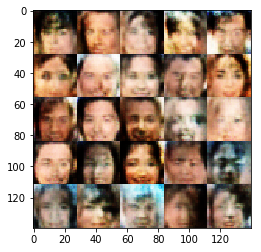

Epoch 1/1... Batch 1210... Discriminator Loss: 1.1307... Generator Loss: 1.2375
Epoch 1/1... Batch 1220... Discriminator Loss: 1.0186... Generator Loss: 0.8692
Epoch 1/1... Batch 1230... Discriminator Loss: 0.4125... Generator Loss: 2.6524
Epoch 1/1... Batch 1240... Discriminator Loss: 0.8508... Generator Loss: 0.8533
Epoch 1/1... Batch 1250... Discriminator Loss: 0.7318... Generator Loss: 0.9435
Epoch 1/1... Batch 1260... Discriminator Loss: 1.1356... Generator Loss: 0.5418
Epoch 1/1... Batch 1270... Discriminator Loss: 1.0960... Generator Loss: 0.8702
Epoch 1/1... Batch 1280... Discriminator Loss: 0.9966... Generator Loss: 1.1893
Epoch 1/1... Batch 1290... Discriminator Loss: 1.1981... Generator Loss: 0.6194
Epoch 1/1... Batch 1300... Discriminator Loss: 1.1349... Generator Loss: 0.7919


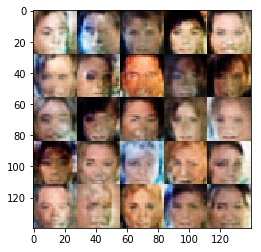

Epoch 1/1... Batch 1310... Discriminator Loss: 1.1453... Generator Loss: 0.7155
Epoch 1/1... Batch 1320... Discriminator Loss: 0.5403... Generator Loss: 1.4914
Epoch 1/1... Batch 1330... Discriminator Loss: 0.9200... Generator Loss: 2.8749
Epoch 1/1... Batch 1340... Discriminator Loss: 0.7192... Generator Loss: 1.7748
Epoch 1/1... Batch 1350... Discriminator Loss: 0.5710... Generator Loss: 2.2202
Epoch 1/1... Batch 1360... Discriminator Loss: 0.5167... Generator Loss: 1.9290
Epoch 1/1... Batch 1370... Discriminator Loss: 0.3372... Generator Loss: 2.3526
Epoch 1/1... Batch 1380... Discriminator Loss: 0.9795... Generator Loss: 2.4261
Epoch 1/1... Batch 1390... Discriminator Loss: 1.6364... Generator Loss: 2.7694
Epoch 1/1... Batch 1400... Discriminator Loss: 0.9294... Generator Loss: 1.0560


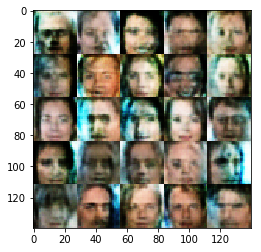

Epoch 1/1... Batch 1410... Discriminator Loss: 1.3345... Generator Loss: 0.6012
Epoch 1/1... Batch 1420... Discriminator Loss: 0.9514... Generator Loss: 1.0732
Epoch 1/1... Batch 1430... Discriminator Loss: 1.0519... Generator Loss: 0.9394
Epoch 1/1... Batch 1440... Discriminator Loss: 0.8258... Generator Loss: 0.9697
Epoch 1/1... Batch 1450... Discriminator Loss: 1.1356... Generator Loss: 0.7120
Epoch 1/1... Batch 1460... Discriminator Loss: 0.7063... Generator Loss: 2.3009
Epoch 1/1... Batch 1470... Discriminator Loss: 0.9895... Generator Loss: 0.6881
Epoch 1/1... Batch 1480... Discriminator Loss: 1.8448... Generator Loss: 2.6762
Epoch 1/1... Batch 1490... Discriminator Loss: 0.9367... Generator Loss: 2.1778
Epoch 1/1... Batch 1500... Discriminator Loss: 1.1886... Generator Loss: 0.6031


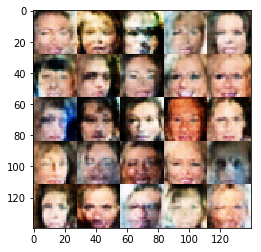

Epoch 1/1... Batch 1510... Discriminator Loss: 1.2465... Generator Loss: 0.4925
Epoch 1/1... Batch 1520... Discriminator Loss: 1.6534... Generator Loss: 0.2875
Epoch 1/1... Batch 1530... Discriminator Loss: 1.1864... Generator Loss: 0.6645
Epoch 1/1... Batch 1540... Discriminator Loss: 0.8968... Generator Loss: 1.4354
Epoch 1/1... Batch 1550... Discriminator Loss: 0.9968... Generator Loss: 0.9142
Epoch 1/1... Batch 1560... Discriminator Loss: 1.4865... Generator Loss: 0.4270
Epoch 1/1... Batch 1570... Discriminator Loss: 1.2807... Generator Loss: 0.9792
Epoch 1/1... Batch 1580... Discriminator Loss: 0.4403... Generator Loss: 2.4329
Epoch 1/1... Batch 1590... Discriminator Loss: 1.0408... Generator Loss: 0.9073
Epoch 1/1... Batch 1600... Discriminator Loss: 0.5498... Generator Loss: 1.3579


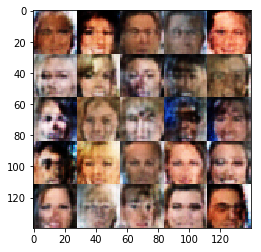

Epoch 1/1... Batch 1610... Discriminator Loss: 1.3717... Generator Loss: 0.4422
Epoch 1/1... Batch 1620... Discriminator Loss: 0.4896... Generator Loss: 1.7940
Epoch 1/1... Batch 1630... Discriminator Loss: 0.6721... Generator Loss: 1.7467
Epoch 1/1... Batch 1640... Discriminator Loss: 0.9111... Generator Loss: 2.8934
Epoch 1/1... Batch 1650... Discriminator Loss: 1.3452... Generator Loss: 0.4615
Epoch 1/1... Batch 1660... Discriminator Loss: 0.9859... Generator Loss: 0.8603
Epoch 1/1... Batch 1670... Discriminator Loss: 1.1300... Generator Loss: 0.6904
Epoch 1/1... Batch 1680... Discriminator Loss: 0.5573... Generator Loss: 1.5133
Epoch 1/1... Batch 1690... Discriminator Loss: 1.2123... Generator Loss: 0.5984
Epoch 1/1... Batch 1700... Discriminator Loss: 1.2401... Generator Loss: 0.8833


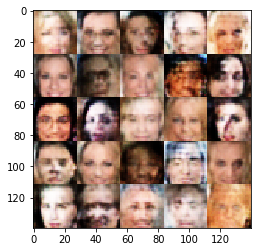

Epoch 1/1... Batch 1710... Discriminator Loss: 1.1375... Generator Loss: 0.6916
Epoch 1/1... Batch 1720... Discriminator Loss: 0.9151... Generator Loss: 0.7648
Epoch 1/1... Batch 1730... Discriminator Loss: 1.3086... Generator Loss: 0.6873
Epoch 1/1... Batch 1740... Discriminator Loss: 0.4449... Generator Loss: 2.6260
Epoch 1/1... Batch 1750... Discriminator Loss: 0.8245... Generator Loss: 1.0819
Epoch 1/1... Batch 1760... Discriminator Loss: 1.0400... Generator Loss: 1.1756
Epoch 1/1... Batch 1770... Discriminator Loss: 1.5125... Generator Loss: 0.3410
Epoch 1/1... Batch 1780... Discriminator Loss: 1.9334... Generator Loss: 0.2119
Epoch 1/1... Batch 1790... Discriminator Loss: 1.4984... Generator Loss: 0.3694
Epoch 1/1... Batch 1800... Discriminator Loss: 1.7819... Generator Loss: 0.2853


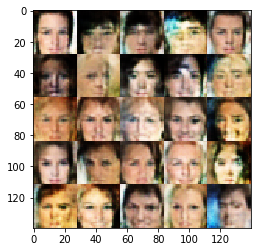

Epoch 1/1... Batch 1810... Discriminator Loss: 0.5280... Generator Loss: 1.5950
Epoch 1/1... Batch 1820... Discriminator Loss: 0.7552... Generator Loss: 1.6286
Epoch 1/1... Batch 1830... Discriminator Loss: 0.6851... Generator Loss: 1.7299
Epoch 1/1... Batch 1840... Discriminator Loss: 1.1654... Generator Loss: 0.6757
Epoch 1/1... Batch 1850... Discriminator Loss: 0.4523... Generator Loss: 2.5225
Epoch 1/1... Batch 1860... Discriminator Loss: 0.9835... Generator Loss: 0.8665
Epoch 1/1... Batch 1870... Discriminator Loss: 0.6581... Generator Loss: 1.1638
Epoch 1/1... Batch 1880... Discriminator Loss: 1.0716... Generator Loss: 0.8155
Epoch 1/1... Batch 1890... Discriminator Loss: 0.8367... Generator Loss: 1.2270
Epoch 1/1... Batch 1900... Discriminator Loss: 0.9503... Generator Loss: 2.0541


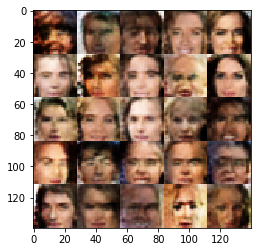

Epoch 1/1... Batch 1910... Discriminator Loss: 1.1157... Generator Loss: 1.2152
Epoch 1/1... Batch 1920... Discriminator Loss: 0.5752... Generator Loss: 1.6151
Epoch 1/1... Batch 1930... Discriminator Loss: 0.9213... Generator Loss: 0.7855
Epoch 1/1... Batch 1940... Discriminator Loss: 0.5421... Generator Loss: 1.7556
Epoch 1/1... Batch 1950... Discriminator Loss: 1.1498... Generator Loss: 0.5335
Epoch 1/1... Batch 1960... Discriminator Loss: 1.1174... Generator Loss: 0.6224
Epoch 1/1... Batch 1970... Discriminator Loss: 0.7636... Generator Loss: 0.9155
Epoch 1/1... Batch 1980... Discriminator Loss: 1.0382... Generator Loss: 0.6793
Epoch 1/1... Batch 1990... Discriminator Loss: 1.1458... Generator Loss: 0.5650
Epoch 1/1... Batch 2000... Discriminator Loss: 1.1424... Generator Loss: 0.7836


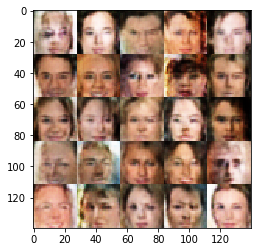

Epoch 1/1... Batch 2010... Discriminator Loss: 1.3051... Generator Loss: 0.4192
Epoch 1/1... Batch 2020... Discriminator Loss: 0.7343... Generator Loss: 1.0285
Epoch 1/1... Batch 2030... Discriminator Loss: 0.8149... Generator Loss: 1.9541
Epoch 1/1... Batch 2040... Discriminator Loss: 1.7066... Generator Loss: 0.2817
Epoch 1/1... Batch 2050... Discriminator Loss: 2.5035... Generator Loss: 0.1161
Epoch 1/1... Batch 2060... Discriminator Loss: 1.0103... Generator Loss: 0.9018
Epoch 1/1... Batch 2070... Discriminator Loss: 0.8476... Generator Loss: 0.9880
Epoch 1/1... Batch 2080... Discriminator Loss: 1.0772... Generator Loss: 0.6632
Epoch 1/1... Batch 2090... Discriminator Loss: 1.0721... Generator Loss: 0.8228
Epoch 1/1... Batch 2100... Discriminator Loss: 1.3012... Generator Loss: 0.5026


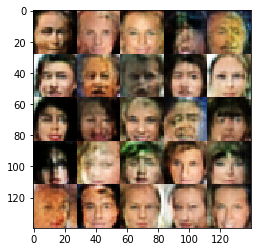

Epoch 1/1... Batch 2110... Discriminator Loss: 0.4341... Generator Loss: 2.0202
Epoch 1/1... Batch 2120... Discriminator Loss: 0.6160... Generator Loss: 2.5664
Epoch 1/1... Batch 2130... Discriminator Loss: 0.9814... Generator Loss: 1.5199
Epoch 1/1... Batch 2140... Discriminator Loss: 0.6349... Generator Loss: 2.1696
Epoch 1/1... Batch 2150... Discriminator Loss: 1.2126... Generator Loss: 0.5127
Epoch 1/1... Batch 2160... Discriminator Loss: 0.8224... Generator Loss: 1.1340
Epoch 1/1... Batch 2170... Discriminator Loss: 1.2460... Generator Loss: 0.5112
Epoch 1/1... Batch 2180... Discriminator Loss: 1.2787... Generator Loss: 0.5134
Epoch 1/1... Batch 2190... Discriminator Loss: 1.1124... Generator Loss: 0.9768
Epoch 1/1... Batch 2200... Discriminator Loss: 1.0901... Generator Loss: 1.1779


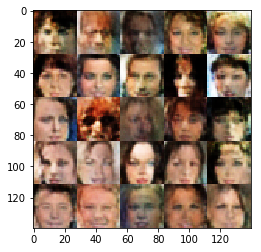

Epoch 1/1... Batch 2210... Discriminator Loss: 1.5988... Generator Loss: 0.3030
Epoch 1/1... Batch 2220... Discriminator Loss: 0.9622... Generator Loss: 0.8733
Epoch 1/1... Batch 2230... Discriminator Loss: 1.1896... Generator Loss: 0.5851
Epoch 1/1... Batch 2240... Discriminator Loss: 1.2964... Generator Loss: 0.6659
Epoch 1/1... Batch 2250... Discriminator Loss: 1.2271... Generator Loss: 0.5616
Epoch 1/1... Batch 2260... Discriminator Loss: 1.1094... Generator Loss: 1.0708
Epoch 1/1... Batch 2270... Discriminator Loss: 0.6939... Generator Loss: 0.9309
Epoch 1/1... Batch 2280... Discriminator Loss: 1.0483... Generator Loss: 0.8512
Epoch 1/1... Batch 2290... Discriminator Loss: 0.9574... Generator Loss: 0.7905
Epoch 1/1... Batch 2300... Discriminator Loss: 0.8821... Generator Loss: 1.1327


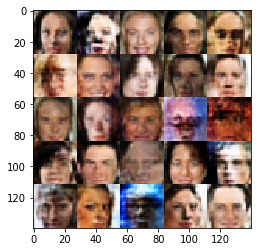

Epoch 1/1... Batch 2310... Discriminator Loss: 1.9466... Generator Loss: 0.2027
Epoch 1/1... Batch 2320... Discriminator Loss: 1.0058... Generator Loss: 0.8331
Epoch 1/1... Batch 2330... Discriminator Loss: 1.1467... Generator Loss: 1.0277
Epoch 1/1... Batch 2340... Discriminator Loss: 0.8971... Generator Loss: 0.8538
Epoch 1/1... Batch 2350... Discriminator Loss: 1.3552... Generator Loss: 2.2582
Epoch 1/1... Batch 2360... Discriminator Loss: 0.9070... Generator Loss: 1.1041
Epoch 1/1... Batch 2370... Discriminator Loss: 0.5451... Generator Loss: 1.5179
Epoch 1/1... Batch 2380... Discriminator Loss: 1.4880... Generator Loss: 0.3226
Epoch 1/1... Batch 2390... Discriminator Loss: 0.4083... Generator Loss: 2.3610
Epoch 1/1... Batch 2400... Discriminator Loss: 1.0615... Generator Loss: 1.1334


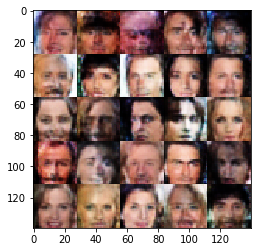

Epoch 1/1... Batch 2410... Discriminator Loss: 1.5457... Generator Loss: 2.1160
Epoch 1/1... Batch 2420... Discriminator Loss: 0.7792... Generator Loss: 0.9974
Epoch 1/1... Batch 2430... Discriminator Loss: 0.9223... Generator Loss: 2.2328
Epoch 1/1... Batch 2440... Discriminator Loss: 1.1405... Generator Loss: 0.5305
Epoch 1/1... Batch 2450... Discriminator Loss: 1.1803... Generator Loss: 1.4928
Epoch 1/1... Batch 2460... Discriminator Loss: 0.2620... Generator Loss: 2.3335
Epoch 1/1... Batch 2470... Discriminator Loss: 1.3489... Generator Loss: 0.7263
Epoch 1/1... Batch 2480... Discriminator Loss: 0.4218... Generator Loss: 1.7502
Epoch 1/1... Batch 2490... Discriminator Loss: 1.0303... Generator Loss: 0.6972
Epoch 1/1... Batch 2500... Discriminator Loss: 0.3502... Generator Loss: 2.5393


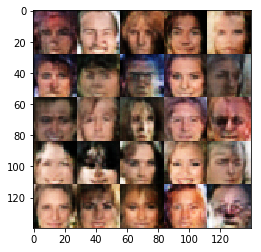

Epoch 1/1... Batch 2510... Discriminator Loss: 1.4367... Generator Loss: 1.2232
Epoch 1/1... Batch 2520... Discriminator Loss: 1.1552... Generator Loss: 0.8850
Epoch 1/1... Batch 2530... Discriminator Loss: 0.7078... Generator Loss: 1.5599
Epoch 1/1... Batch 2540... Discriminator Loss: 1.0037... Generator Loss: 0.7334
Epoch 1/1... Batch 2550... Discriminator Loss: 1.5806... Generator Loss: 0.3255
Epoch 1/1... Batch 2560... Discriminator Loss: 0.4130... Generator Loss: 1.7765
Epoch 1/1... Batch 2570... Discriminator Loss: 0.7485... Generator Loss: 0.8705
Epoch 1/1... Batch 2580... Discriminator Loss: 1.3400... Generator Loss: 0.9833
Epoch 1/1... Batch 2590... Discriminator Loss: 0.7911... Generator Loss: 0.8838
Epoch 1/1... Batch 2600... Discriminator Loss: 1.1297... Generator Loss: 0.6370


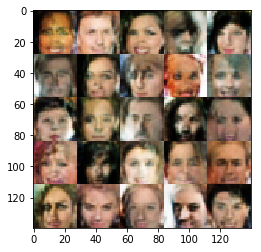

Epoch 1/1... Batch 2610... Discriminator Loss: 0.5876... Generator Loss: 1.4059
Epoch 1/1... Batch 2620... Discriminator Loss: 1.0424... Generator Loss: 1.1028
Epoch 1/1... Batch 2630... Discriminator Loss: 0.6877... Generator Loss: 1.3328
Epoch 1/1... Batch 2640... Discriminator Loss: 0.8102... Generator Loss: 1.0932
Epoch 1/1... Batch 2650... Discriminator Loss: 0.7263... Generator Loss: 1.1982
Epoch 1/1... Batch 2660... Discriminator Loss: 1.1646... Generator Loss: 0.8817
Epoch 1/1... Batch 2670... Discriminator Loss: 0.9834... Generator Loss: 0.6874
Epoch 1/1... Batch 2680... Discriminator Loss: 0.5584... Generator Loss: 1.2797
Epoch 1/1... Batch 2690... Discriminator Loss: 1.3278... Generator Loss: 0.4408
Epoch 1/1... Batch 2700... Discriminator Loss: 1.3334... Generator Loss: 0.4413


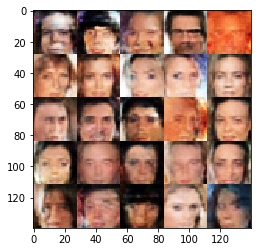

Epoch 1/1... Batch 2710... Discriminator Loss: 0.9937... Generator Loss: 0.7523
Epoch 1/1... Batch 2720... Discriminator Loss: 1.7399... Generator Loss: 0.2850
Epoch 1/1... Batch 2730... Discriminator Loss: 1.3499... Generator Loss: 0.3630
Epoch 1/1... Batch 2740... Discriminator Loss: 0.7724... Generator Loss: 0.9069
Epoch 1/1... Batch 2750... Discriminator Loss: 1.2890... Generator Loss: 0.7213
Epoch 1/1... Batch 2760... Discriminator Loss: 1.0329... Generator Loss: 0.8779
Epoch 1/1... Batch 2770... Discriminator Loss: 1.0003... Generator Loss: 0.6514
Epoch 1/1... Batch 2780... Discriminator Loss: 0.7646... Generator Loss: 0.7961
Epoch 1/1... Batch 2790... Discriminator Loss: 1.1614... Generator Loss: 0.9806
Epoch 1/1... Batch 2800... Discriminator Loss: 0.9575... Generator Loss: 0.8021


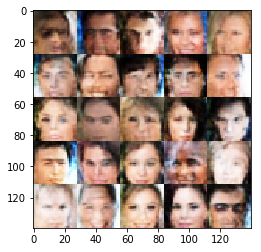

Epoch 1/1... Batch 2810... Discriminator Loss: 1.1234... Generator Loss: 0.5686
Epoch 1/1... Batch 2820... Discriminator Loss: 0.6587... Generator Loss: 1.1119
Epoch 1/1... Batch 2830... Discriminator Loss: 1.1361... Generator Loss: 0.7815
Epoch 1/1... Batch 2840... Discriminator Loss: 1.9356... Generator Loss: 0.2198
Epoch 1/1... Batch 2850... Discriminator Loss: 1.8207... Generator Loss: 0.2458
Epoch 1/1... Batch 2860... Discriminator Loss: 1.0455... Generator Loss: 0.9063
Epoch 1/1... Batch 2870... Discriminator Loss: 1.3271... Generator Loss: 0.6678
Epoch 1/1... Batch 2880... Discriminator Loss: 1.3099... Generator Loss: 0.4974
Epoch 1/1... Batch 2890... Discriminator Loss: 0.9951... Generator Loss: 0.9682
Epoch 1/1... Batch 2900... Discriminator Loss: 1.0063... Generator Loss: 0.7735


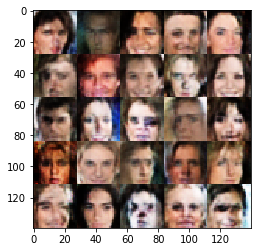

Epoch 1/1... Batch 2910... Discriminator Loss: 0.9369... Generator Loss: 1.0237
Epoch 1/1... Batch 2920... Discriminator Loss: 1.1991... Generator Loss: 0.5547
Epoch 1/1... Batch 2930... Discriminator Loss: 1.0268... Generator Loss: 0.7290
Epoch 1/1... Batch 2940... Discriminator Loss: 1.0617... Generator Loss: 0.6781
Epoch 1/1... Batch 2950... Discriminator Loss: 1.7221... Generator Loss: 0.3090
Epoch 1/1... Batch 2960... Discriminator Loss: 1.1522... Generator Loss: 0.6956
Epoch 1/1... Batch 2970... Discriminator Loss: 0.9030... Generator Loss: 0.9593
Epoch 1/1... Batch 2980... Discriminator Loss: 1.0164... Generator Loss: 1.4114
Epoch 1/1... Batch 2990... Discriminator Loss: 1.2258... Generator Loss: 0.5429
Epoch 1/1... Batch 3000... Discriminator Loss: 0.8874... Generator Loss: 0.9640


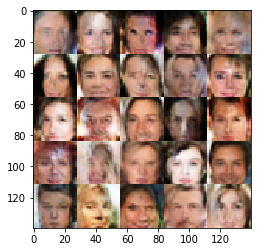

Epoch 1/1... Batch 3010... Discriminator Loss: 0.6780... Generator Loss: 1.2433
Epoch 1/1... Batch 3020... Discriminator Loss: 1.5603... Generator Loss: 0.3012
Epoch 1/1... Batch 3030... Discriminator Loss: 1.2804... Generator Loss: 0.5079
Epoch 1/1... Batch 3040... Discriminator Loss: 0.6020... Generator Loss: 1.5359
Epoch 1/1... Batch 3050... Discriminator Loss: 1.1931... Generator Loss: 0.6437
Epoch 1/1... Batch 3060... Discriminator Loss: 1.2616... Generator Loss: 0.4621
Epoch 1/1... Batch 3070... Discriminator Loss: 1.3971... Generator Loss: 0.4096
Epoch 1/1... Batch 3080... Discriminator Loss: 1.0463... Generator Loss: 0.6074
Epoch 1/1... Batch 3090... Discriminator Loss: 0.3503... Generator Loss: 1.5978
Epoch 1/1... Batch 3100... Discriminator Loss: 2.1730... Generator Loss: 0.1597


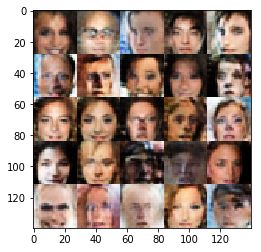

Epoch 1/1... Batch 3110... Discriminator Loss: 1.3568... Generator Loss: 0.4085
Epoch 1/1... Batch 3120... Discriminator Loss: 0.9059... Generator Loss: 1.4036
Epoch 1/1... Batch 3130... Discriminator Loss: 1.0180... Generator Loss: 0.7235
Epoch 1/1... Batch 3140... Discriminator Loss: 0.8302... Generator Loss: 1.1167
Epoch 1/1... Batch 3150... Discriminator Loss: 1.3210... Generator Loss: 0.4543
Epoch 1/1... Batch 3160... Discriminator Loss: 1.2919... Generator Loss: 0.5421


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.

In [ ]:
k